In [1]:
import os
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from anndata import AnnData
import dask.array as da
import snapfish2 as sf
from utils.data import DataTree
dtree = DataTree("../data")
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [14]:
dtree.items()

AttributeError: 'DataTree' object has no attribute 'items'

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
})
adata = loader.create_adata("chr3", {"X": 103, "Y": 103, "Z": 250})
sf.pp.filter_normalize(adata)
sf.pp.axis_weight(adata)

In [4]:
loop = sf.tl.LoopCaller(fdr_cutoff=0.1)
sf.wr.caller_wrapper(loader, loop, "loop_res.tsv")

In [27]:
loader = sf.pp.FOF_CT_Loader("../data/su_cell_2020/chromosome2.csv")
adata = loader.create_adata("chr2")[:100]
sf.pp.filter_normalize(adata, "carr")
# sf.pp.median_pdist(adata)

/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/utils/eval.py:22: ImplicitModificationWarning: Setting element `.varp['raw_var_X']` of view, initializing view as actual.
  adata.varp[f"raw_var_{v}"] = med_sq[i]


In [56]:
loader.chr_ids

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chrX'], dtype=object)

In [35]:
abcpmt = sf.tl.ABCaller(1e5)
a = abcpmt.by_axes_pc(adata)

In [39]:
a = {"a":1, "b":1}
list(a.values())

[1, 1]

In [37]:
a.cpmt.value_counts()

cpmt
1    560
0    375
Name: count, dtype: int64

In [ ]:
from statsmodels.stats import multitest as multi

In [3]:
keys = ["rep1", "rep2", "rep3"]

data_paths = {c:dtree["takei_science_2021", "25Kb", c] for c in keys}
loader = sf.pp.FOF_CT_Loader(data_paths)
ratio = {"X": 103, "Y": 103, "Z": 250}
adata = loader.create_adata("chr3", ratio, obs_cols_add=["Cell_ID"])

type_paths = {c:dtree["takei_science_2021", "cell_type", c] for c in keys}
dfs = sf.pp.FOF_CT_Loader(type_paths).read_data()

sf.pp.add_cell_type(adata, dfs, "Cell_ID", "cluster label")

In [4]:
celltype_dict = {1:'Pvalb', 2:'Vip', 3:'Ndnf', 4:'Sst', 5:'Astro',
                 6:'Micro', 7:'Endo', 8:'Oligo', 9:'Ex'}
adata.obs["cell_type"] = adata.obs["cluster label"].map(celltype_dict)
adata.obs["cell_type"].value_counts()

cell_type
Ex       2514
Endo      264
Astro     233
Pvalb     207
Micro     130
Oligo     107
Vip        90
Sst        81
Ndnf       50
Name: count, dtype: int64

In [5]:
sf.pp.filter_normalize(adata)
loop = sf.tl.LoopCaller()
loop_df = loop.to_bedpe(loop.call_loops(adata), adata)

In [ ]:
tad = sf.tl.TADCaller()
tad.by_pval()

In [6]:
adata1 = adata[adata.obs["cell_type"]=="Endo"]
adata2 = adata[adata.obs["cell_type"]=="Ex"]

diffloop = sf.tl.DiffLoop(adata1, adata2)
res = diffloop.diff_loops(loop_df[loop_df["summit"]])
df = diffloop.to_bedpe(res, 0.1)

Found 3 differential loops, while 25 are not differential loops.


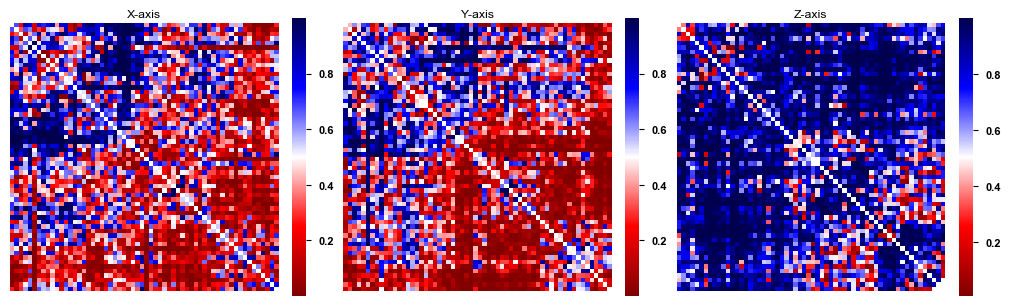

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, c in enumerate(["X", "Y", "Z"]):
    sf.pl.pairwise_heatmap(res["f_pvals"][i], x=f"{c}-axis", ax=axes[i])

In [19]:
tadcaller = sf.tl.TADCaller()
df = tadcaller.by_insulation(adata, 0.04, 2)

In [22]:
df = sf.tl.TADCaller.to_bedpe(df, "insulation", False)

In [3]:
loader = sf.pp.FOF_CT_Loader("../data/su_cell_2020/chromosome2.csv")
adata = loader.create_adata("chr2")

In [4]:
med_dist = sf.tl.median_pdist(adata, inplace=False)

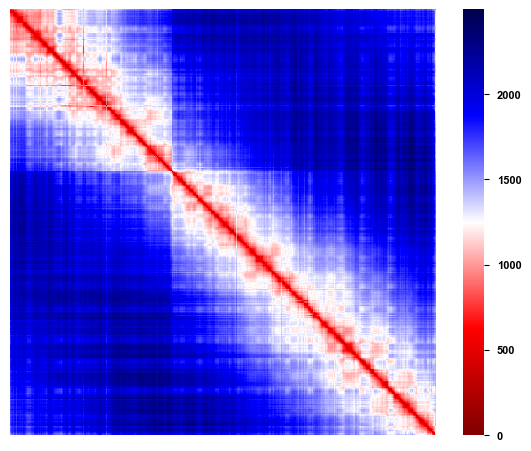

In [5]:
sf.pl.pairwise_heatmap(med_dist, rasterized=True)

/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


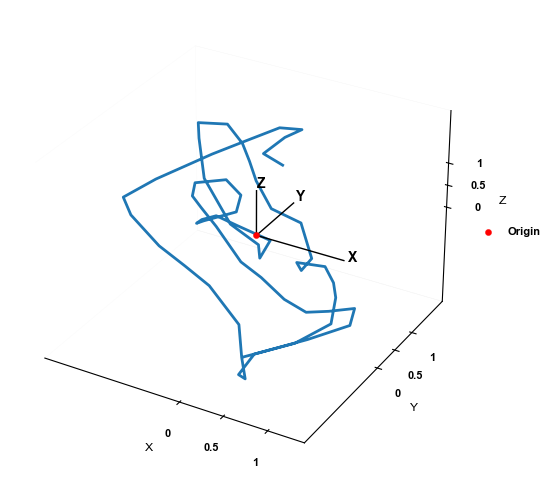

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Parameters
length = 60
points = np.linspace(0, 1, length).reshape(-1, 1)
kernel = 1.0 * Matern(length_scale=0.1, nu=1.5)

gp = GaussianProcessRegressor(kernel=kernel)
mean = np.zeros((length, 1))

# Sample from GP
sample = gp.sample_y(points, n_samples=3, random_state=42)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sample[:, 0], sample[:, 1], sample[:, 2], lw=2)
ax.scatter(0, 0, 0, color='r', label='Origin')

# Show xyz axes at the origin with labels and move ticks
ax.plot([0, 1], [0, 0], [0, 0], color='k', lw=1)
ax.text(1.05, 0, 0, 'X', color='k')
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels(['0', '0.5', '1'])

ax.plot([0, 0], [0, 1], [0, 0], color='k', lw=1)
ax.text(0, 1.05, 0, 'Y', color='k')
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '0.5', '1'])

ax.plot([0, 0], [0, 0], [0, 1], color='k', lw=1)
ax.text(0, 0, 1.05, 'Z', color='k')
ax.set_zticks([0, 0.5, 1])
ax.set_zticklabels(['0', '0.5', '1'])

# Remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()